**Steps followed in this notebook for Sentiment analysis of Tweets**

    1. Importing the raw data of tweets
    2. preprocessing of the tweets
    3. Creating Embeddings using Word2Vec
    4. Building RNN model
    5. Interpreting the model
    6. Evaluating the model
    7. Saving the model
    8. Predition on new tweet

# Import Necessary Library 

In [47]:
import numpy as np # linear algebra
import pandas as pd 
import re 
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding, LSTM, GRU, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "tweet"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('dataset.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
dataset.head()

,sentiment,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
dataset.shape

(1600000, 6)

In [4]:
dataset = dataset[['sentiment', 'tweet']]
dataset.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
#unique values of sentiment
dataset['sentiment'].unique()

array([0, 4])

In [6]:
#replacing 4 with 1 for positive sentiment
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

In [7]:
dataset['sentiment'].value_counts()

sentiment
0    800000
1    800000
Name: count, dtype: int64

**Preprocessing the Text**

The Preprocessing steps taken are:

1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs**: Links starting with 'http' or 'https' or 'www' are replaced by '<url>'.
3. **Replacing Usernames:** Replace @Usernames with word '<user>'. [eg: '@Kaggle' to '<user>'].
4. **Replacing Emojis:** Replace emojis by using a regex expression. [eg: ':)' to '<smile>']
5. **Replacing Contractions:** Replacing contractions with their meanings. [eg: "can't" to 'can not']
6. **Removing Non-Alphabets:** Replacing characters except Digits, Alphabets and pre-defined Symbols with a space.

In [8]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

In [9]:
contractions_dict

{"'aight": 'alright',
 "ain't": 'is not',
 "amn't": 'am not',
 "aren't": 'are not',
 "can't": 'cannot',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "daren't": 'dare not',
 "daresn't": 'dare not',
 "dasn't": 'dare not',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 'dunno': 'do not know',
 "d'ye": 'do you',
 "e'er": 'ever',
 "everybody's": 'everybody is',
 "everyone's": 'everyone is',
 'finna': 'fixing',
 "g'day": 'good day',
 'gimme': 'give me',
 "giv'n": 'given',
 'gonna': 'going to',
 "gon't": 'go not',
 'gotta': 'got to',
 "hadn't": 'had not',
 "had've": 'had have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had',
 "he'll": 'he will',
 "he's": 'he is',
 "he've": 'he have',
 "how'd": 'how did',
 'howdy': 'how do you do',
 "how'll": 'how will',
 "how're": 'how are',
 "how's": 'how is',
 "i'd\ti": 'had',
 "i'd've": 'i would have',
 "i'll": 'i will',
 "i'm": 'i am',
 "i'm'a": 'i am abo

In [10]:
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [11]:
dataset['processed_text'] = dataset.tweet.apply(preprocess_apply)

In [12]:
dataset.head()

,sentiment,tweet,processed_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",<user> <url> awww thatis a bummer you sho...
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,<user> i dived many times for the ball manage...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",<user> no it is not behaving at all i am mad...


In [13]:
dataset['tweet'][0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [14]:
dataset['processed_text'][0]

'<user> <url>   awww  thatis a bummer   you shoulda got david carr of third day to do it  <smile>'

# Split the Dataset

In [15]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=32, stratify=y_data)

In [16]:
X_train.shape, X_test.shape

((1120000,), (480000,))

In [17]:
y_train.shape, y_test.shape

((1120000,), (480000,))

# Construction of Embedding Matrix
Steps are:

    1.Word Embedding

    2. Tokenization
    
    3. Adding Pad Sequence

### Creating Word Embedding Using Word2Vec

In [18]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

#creating the List of words for training data
Word2Vec_training_data = list(map(lambda x: x.split(), X_train))

In [19]:
Word2Vec_training_data[0]

['i',
 'keep',
 'checking',
 'my',
 'phone',
 'for',
 'msgs',
 'then',
 'remembering',
 'it',
 'is',
 'not',
 'on',
 'silent',
 'any',
 'more',
 'nigelnofriends']

In [20]:
word2vec_model = Word2Vec(Word2Vec_training_data,
                        vector_size=Embedding_dimensions,
                        workers=8,
                        min_count=5)

In [21]:
word2vec_model.wv[1]

array([-0.5405036 ,  1.6441685 ,  0.54598355,  1.5070688 ,  2.702674  ,
       -0.41091958,  1.1392932 , -0.3064294 ,  0.05259093,  0.25381744,
        0.5884541 , -0.02802609, -0.9162665 , -0.6248418 , -0.80790424,
        0.04709477,  2.4940364 ,  0.07873262, -1.4607021 ,  1.2254896 ,
       -0.06806345, -1.1281004 , -0.2846424 ,  0.74957955, -0.93601996,
       -0.27280873, -1.46309   , -1.3860933 ,  0.8524527 ,  1.2181547 ,
       -0.05021529, -0.9194904 ,  2.014478  , -0.47694442,  1.0451741 ,
       -0.27951923,  1.6602069 ,  0.29806057,  0.2951726 , -0.4084062 ,
       -1.8582581 , -0.86441255, -1.4716915 ,  1.2801223 , -0.16311353,
        1.3116359 ,  0.07192598, -1.1676611 ,  0.9905096 , -0.7324635 ,
       -0.30750343, -1.5038117 ,  0.8901792 , -0.4778512 ,  1.2813741 ,
       -0.14205676,  0.03791191, -0.74629563,  0.9905731 ,  1.2515986 ,
       -1.5963403 ,  1.0087422 ,  1.9365371 , -0.8795454 , -0.28215486,
       -0.32059833,  1.4584459 ,  1.3519338 , -2.3920674 ,  2.92

### Tokenization

In [22]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
# print("Tokenizer vocab length:", vocab_length)

### Padding

In [23]:
input_length = 60

In [24]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1120000, 60)
X_test.shape : (480000, 60)


In [25]:
# X_train[0]

In [26]:
# second_key, second_value = list(tokenizer.word_index.items())[1]
# print("Second Key:", second_key)
# print("Second Value:", second_value)

### Embedding Matrix

In [27]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


In [28]:
# Reverse the mapping of tokens to words
index_to_word = {token: word for word, token in tokenizer.word_index.items()}
# fifth_word = index_to_word[5]
# fifth_word

In [29]:
# embedding_matrix[5]

In [30]:
# word2vec_model.wv.most_similar('man')

# Simple RNN

1. Define the Model Architecture

2. Train on training data

3. Evaluate model's performance

4. Save the model

5. Test on new unseen data

In [31]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        SimpleRNN(100, return_sequences=False),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model_Simple_RNN")
    return model

In [32]:
training_model = getModel()
training_model.summary()

2023-12-06 10:46:10.110199: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "Sentiment_Model_Simple_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           6000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6021733 (22.97 MB)
Trainable params: 21733 (84.89 KB)
Non-trainable params: 6000000 (22.89 MB)
_________________________________________________________________


In [33]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    verbose=1,
)

Epoch 1/12
575/985 [================>.............] - ETA: 34s - loss: 0.5151 - accuracy: 0.7479

985/985 [==============================] - 91s 90ms/step - loss: 0.4932 - accuracy: 0.7622 - val_loss: 0.4516 - val_accuracy: 0.7895
Epoch 2/12
985/985 [==============================] - 87s 89ms/step - loss: 0.4489 - accuracy: 0.7902 - val_loss: 0.4454 - val_accuracy: 0.7942
Epoch 3/12
985/985 [==============================] - 87s 89ms/step - loss: 0.4457 - accuracy: 0.7919 - val_loss: 0.4365 - val_accuracy: 0.7989
Epoch 4/12
985/985 [==============================] - 87s 89ms/step - loss: 0.4326 - accuracy: 0.8006 - val_loss: 0.4316 - val_accuracy: 0.8010
Epoch 5/12
985/985 [==============================] - 87s 89ms/step - loss: 0.4223 - accuracy: 0.8056 - val_loss: 0.4221 - val_accuracy: 0.8047
Epoch 6/12
985/985 [==============================] - 87s 89ms/step - loss: 0.4154 - accuracy: 0.8090 - val_loss: 0.4135 - val_accuracy: 0.8097
Epoch 7/12
985/985 [==============================] - 87s 89ms/step - loss: 0.4103 - accuracy: 0.8116 - val_loss: 0.4134 - val_accuracy: 0.8096
Epo

**Evaluating the Model**

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

 2011/15000 [===>..........................] - ETA: 1:56

15000/15000 [==============================] - 136s 9ms/step
Test accuracy_SimpleRNN: 0.8152520833333333
Confusion Matrix: Simple RNN


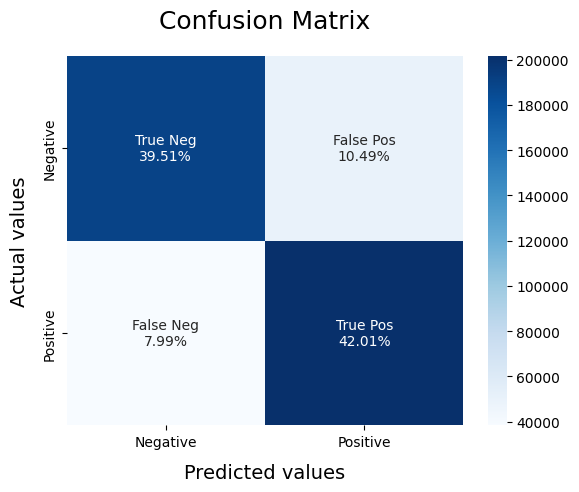

In [36]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy_SimpleRNN: {accuracy}")

# Printing out the Evaluation metrics. 
print ("Confusion Matrix: Simple RNN")
ConfusionMatrix(y_pred, y_test)

**SAVING THE MODEL**

In [37]:
 # Saving Word2Vec-Model
word2vec_model.wv.save('Word2Vec-twitter-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-twitter-100-trainable')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('Saved Models/Sentiment-SimpleRNN')
training_model.save_weights("Model Weights/weights_SimpleRNN")

INFO:tensorflow:Assets written to: Saved Models/Sentiment-SimpleRNN/assets


INFO:tensorflow:Assets written to: Saved Models/Sentiment-SimpleRNN/assets


**Prediction on new data**

In [38]:
# Load the Word2Vec model as a KeyedVectors object
word2vec_model1 = KeyedVectors.load('Word2Vec-twitter-100')


# Load the tokenizer
with open('Tokenizer.pickle', 'rb') as file:
    tokenizer = pickle.load(file)

# Load the TF-Model
training_model = load_model('Saved Models/Sentiment-SimpleRNN')

In [39]:
new_tweet = "Today has been a terrible day. Nothing is going my way, and it feels like everything is falling apart. #badluck #feelingdown 😞"

# Tokenize and pad the new tweet
input_length = 60  # Adjust this to match the input length used during training
new_tweet_tokens = tokenizer.texts_to_sequences([new_tweet])
new_tweet_tokens_padded = pad_sequences(new_tweet_tokens, maxlen=input_length)

In [40]:
# Predict sentiment for the new tweet
sentiment_probabilities = training_model.predict(new_tweet_tokens_padded)

# If it's binary sentiment classification (positive/negative), you can use argmax to get the predicted sentiment
predicted_sentiment = "Positive" if sentiment_probabilities[0][0] > 0.5 else "Negative"

print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 [==============================] - 0s 254ms/step
Predicted Sentiment: Negative


# LSTM

Model: "Sentiment_Model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 100)           6000000   
                                                                 
 lstm (LSTM)                 (None, 60, 100)           80400     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                6464      
                                                                 
 dropout_2 (Dropout)         (None, 64)       

985/985 [==============================] - 599s 602ms/step - loss: 0.4712 - accuracy: 0.7859 - val_loss: 0.4062 - val_accuracy: 0.8129
Epoch 2/5
985/985 [==============================] - 587s 596ms/step - loss: 0.4279 - accuracy: 0.8124 - val_loss: 0.3939 - val_accuracy: 0.8193
Epoch 3/5
985/985 [==============================] - 586s 595ms/step - loss: 0.4154 - accuracy: 0.8195 - val_loss: 0.3863 - val_accuracy: 0.8249
Epoch 4/5
985/985 [==============================] - 586s 595ms/step - loss: 0.4073 - accuracy: 0.8232 - val_loss: 0.3811 - val_accuracy: 0.8283
Epoch 5/5
15000/15000 [==============================] - 695s 46ms/step
Test accuracy_LSTM: 0.8301354166666667
Confusion Matrix: LSTM


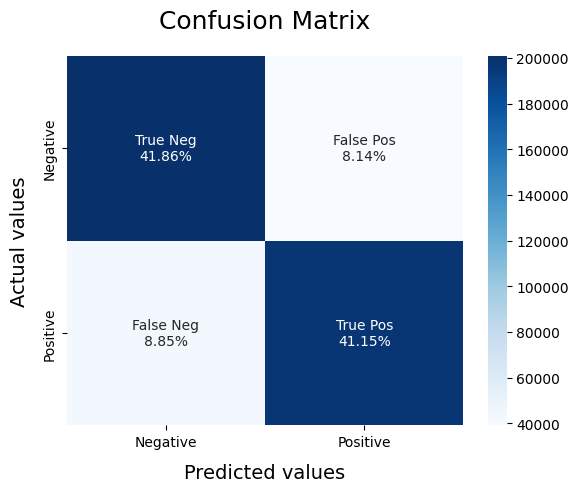

In [41]:
def getModel_lstm():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        LSTM(100, return_sequences=True),
        Dropout(0.5),
        LSTM(100),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(16, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model_LSTM")
    return model

training_model = getModel_lstm()
training_model.summary()

training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=5,
    validation_split=0.1,
    verbose=1,
)

## Evaluating the model
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy_LSTM: {accuracy}")

# Printing out the Evaluation metrics. 
print ("Confusion Matrix: LSTM")
ConfusionMatrix(y_pred, y_test)

In [42]:
## Save model
# Saving the TF-Model.
training_model.save('Saved Models/Sentiment-LSTM')
training_model.save_weights("Model Weights/weights_LSTM")

# Load the Word2Vec model as a KeyedVectors object
word2vec_model1 = KeyedVectors.load('Word2Vec-twitter-100')


# Load the tokenizer
with open('Tokenizer.pickle', 'rb') as file:
    tokenizer = pickle.load(file)

# Load the TF-Model
training_model = load_model('Saved Models/Sentiment-LSTM')

INFO:tensorflow:Assets written to: Saved Models/Sentiment-LSTM/assets


INFO:tensorflow:Assets written to: Saved Models/Sentiment-LSTM/assets


In [43]:
## Predictions on new data
new_tweet = "Today has been a terrible day. Nothing is going my way, and it feels like everything is falling apart. #badluck #feelingdown 😞"

# Tokenize and pad the new tweet
input_length = 60  # Adjust this to match the input length used during training
new_tweet_tokens = tokenizer.texts_to_sequences([new_tweet])
new_tweet_tokens_padded = pad_sequences(new_tweet_tokens, maxlen=input_length)

# Predict sentiment for the new tweet
sentiment_probabilities = training_model.predict(new_tweet_tokens_padded)

# If it's binary sentiment classification (positive/negative), you can use argmax to get the predicted sentiment
predicted_sentiment = "Positive" if sentiment_probabilities[0][0] > 0.5 else "Negative"

print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 [==============================] - 3s 3s/step
Predicted Sentiment: Negative


# Bidirectional LSTM

Model: "Sentiment_Model_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 100)           6000000   
                                                                 
 bidirectional (Bidirection  (None, 60, 200)           160800    
 al)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 60, 200)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               240800    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 64)     

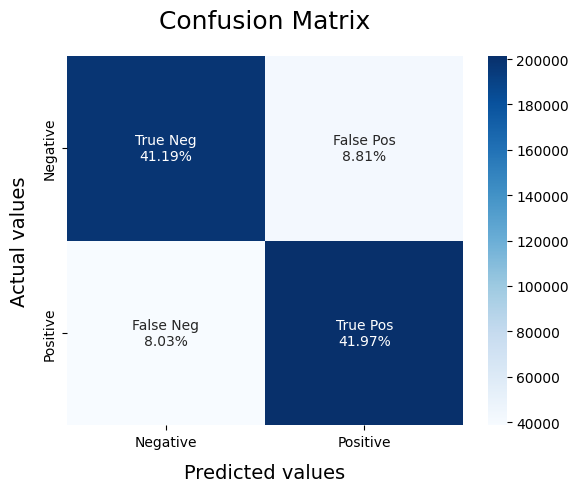

In [44]:
def getModel_bilstm():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(100)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(16, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model_BiLSTM")
    return model


training_model = getModel_bilstm()
training_model.summary()

training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=5,
    validation_split=0.1,
    verbose=1,
)

## Evaluating the model
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy_BiLSTM: {accuracy}")

# Printing out the Evaluation metrics. 
print ("Confusion Matrix:BiLSTM")
ConfusionMatrix(y_pred, y_test)

In [45]:
## Save model
# Saving the TF-Model.
training_model.save('Saved Models/Sentiment-BiLSTM')
training_model.save_weights("Model Weights/weights_BiLSTM")

# Load the Word2Vec model as a KeyedVectors object
word2vec_model1 = KeyedVectors.load('Word2Vec-twitter-100')


# Load the tokenizer
with open('Tokenizer.pickle', 'rb') as file:
    tokenizer = pickle.load(file)

# Load the TF-Model
training_model = load_model('Saved Models/Sentiment-BiLSTM')

INFO:tensorflow:Assets written to: Saved Models/Sentiment-BiLSTM/assets


INFO:tensorflow:Assets written to: Saved Models/Sentiment-BiLSTM/assets


In [46]:
## Predictions on new data
new_tweet = "Today has been a terrible day. Nothing is going my way, and it feels like everything is falling apart. #badluck #feelingdown 😞"

# Tokenize and pad the new tweet
input_length = 60  # Adjust this to match the input length used during training
new_tweet_tokens = tokenizer.texts_to_sequences([new_tweet])
new_tweet_tokens_padded = pad_sequences(new_tweet_tokens, maxlen=input_length)

# Predict sentiment for the new tweet
sentiment_probabilities = training_model.predict(new_tweet_tokens_padded)

# If it's binary sentiment classification (positive/negative), you can use argmax to get the predicted sentiment
predicted_sentiment = "Positive" if sentiment_probabilities[0][0] > 0.5 else "Negative"

print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 [==============================] - 2s 2s/step
Predicted Sentiment: Negative


# CNN 

Model: "Sentiment_Model_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 60, 100)           6000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 56, 128)           64128     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 28, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 26, 64)            24640     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            (None, 32)        

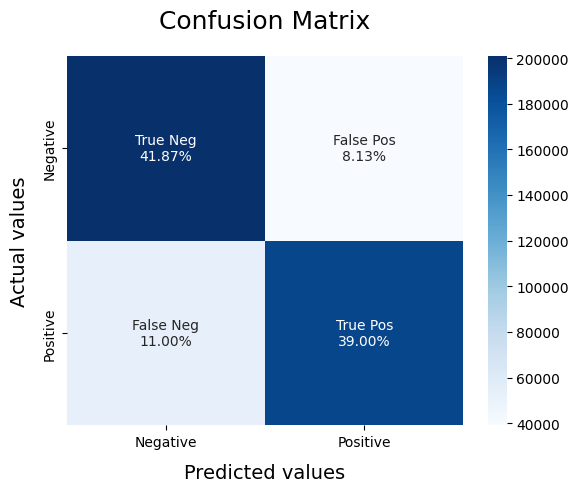

In [49]:
def getModel_cnn():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model_CNN")
    return model


training_model = getModel_cnn()
training_model.summary()

training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=15,
    validation_split=0.1,
    verbose=1,
)

## Evaluating the model
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy_CNN: {accuracy}")

# Printing out the Evaluation metrics. 
print ("Confusion Matrix:CNN")
ConfusionMatrix(y_pred, y_test)

In [50]:
## Save model
# Saving the TF-Model.
training_model.save('Saved Models/Sentiment-CNN')
training_model.save_weights("Model Weights/weights_CNN")

# Load the Word2Vec model as a KeyedVectors object
word2vec_model1 = KeyedVectors.load('Word2Vec-twitter-100')


# Load the tokenizer
with open('Tokenizer.pickle', 'rb') as file:
    tokenizer = pickle.load(file)

# Load the TF-Model
training_model = load_model('Saved Models/Sentiment-CNN')

INFO:tensorflow:Assets written to: Saved Models/Sentiment-CNN/assets


INFO:tensorflow:Assets written to: Saved Models/Sentiment-CNN/assets


In [51]:
## Predictions on new data
new_tweet = "Today has been a terrible day. Nothing is going my way, and it feels like everything is falling apart. #badluck #feelingdown 😞"

# Tokenize and pad the new tweet
input_length = 60  # Adjust this to match the input length used during training
new_tweet_tokens = tokenizer.texts_to_sequences([new_tweet])
new_tweet_tokens_padded = pad_sequences(new_tweet_tokens, maxlen=input_length)

# Predict sentiment for the new tweet
sentiment_probabilities = training_model.predict(new_tweet_tokens_padded)

# If it's binary sentiment classification (positive/negative), you can use argmax to get the predicted sentiment
predicted_sentiment = "Positive" if sentiment_probabilities[0][0] > 0.5 else "Negative"

print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 [==============================] - 0s 129ms/step
Predicted Sentiment: Negative
